*Go to [https://gist.github.com/illarionovEA/c8f92ded14bde4fcc36940b5dda01ba3](https://gist.github.com/illarionovEA/c8f92ded14bde4fcc36940b5dda01ba3) to view the Notebook with all images*

# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Random number generators

Do you know what actually happens when you call function for generating random numbers, e.g. ```np.random.rand()```?

What is a source of randomness in you computer?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

If we look under the hood of any standard generator we will observe nothing but a **fully deterministic algorithm**. All it can do is to produce a **fully deterministic sequence** of numbers. Anytime, anywhere, at any device you will obtain absolutely the same sequence. That is why they are called pseudorandom number generators.

**Never use standard random generators in cryptographic applications!**

For "true" generators based on natural sources of randomness see e.g. https://www.random.org/.

## Generating of uniform random numbers

You can browse a lot of methods  for generating random numbers [here](https://en.wikipedia.org/wiki/List_of_random_number_generators). We consider the most common one which is a Linear congruential generator (LCG). When you call ```rand()``` in C/C++, you actually call LCG.

Linear congruential generator produces the following sequence:
$$ z_{i+1} = (az_i + c) \mod m $$

The number $z_0$ is called the *seed*, and setting it allows us to have a reproducible sequence of “random” numbers. The LCG is typically coded to return $z/m$, a floating point number in (0, 1). Obviosuly, this can be easily scaled to any other range $(a,b)$.

Let's implement some LCG:

In [1]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Check the sequence it produces:

In [2]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

One should carefully choose constants $m$, $a$ and $c$. Things can easily go bad if they are choosen "at random":

In [3]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Samples distribution also mimics uniform distribution

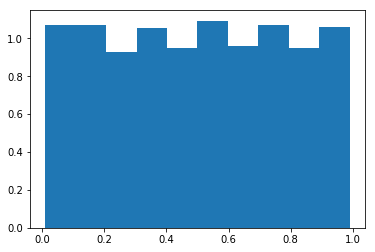

In [5]:
import matplotlib.pyplot as plt
plt.hist(random, density=True)
plt.show()

However, spectral test shows that samples are bunched up on five lines

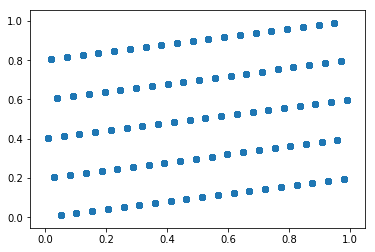

In [6]:
plt.scatter(random[1:], random[:-1])
plt.show()

Appropriate constants produce more "random" scatter

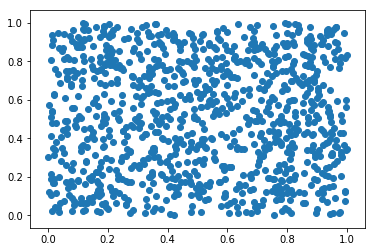

In [7]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

There is a number of tests that check how good random generator works. See [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests) for example.

## Sampling from distributions

Let's suppose we have some generator for uniform random numbers in (0, 1). How we can sample from arbitrary distribution $F$?

### Inverse transform method

Next proposition gives an idea of the *inverse transform method*.

Proove that if $\xi$ is uniform in $[0,1]$ then $F^{-1}(\xi)$ is $F$-distributed. For which $F$ does it hold?

### Exercise
Sample 1000 random numbers from $Exp(\lambda)$ distribution using the inverse transform method. Plot the histogram and the true probability density function (PDF).

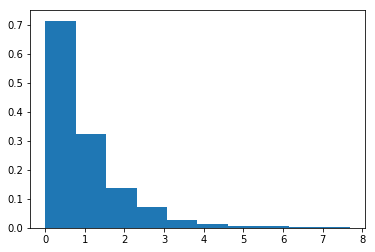

In [8]:
import math
def Exp(parametr = 1):
    random = [math.log(parametr/rng())/parametr for i in range(1000)]
    return random
Exp()
plt.hist(Exp(), density = True)
plt.show()


### Rejection sampling (Accept-reject method)

Next figure shows an idea:

<img src="https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png" style="width: 50%;"/>

We sample points from proposal PDF (which is known and is easy to sample from) and discard points that are above the target PDF. 

### Exercise
Proove that the accept-reject method is valid. Sample 100 points from truncated cauchy distribution given below using uniform random number generator and the accept-reject method. Plot obtained histogram and the true pdf.

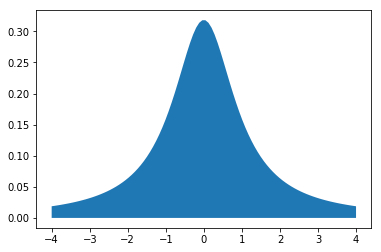

In [9]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

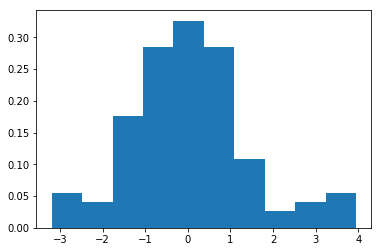

In [10]:
a1 = [(rng()-0.5)*8 for i in range(1000)]
a2 = [(rng())* 1 for i in range(1000)]
a3 = []
for j in range(1000):
    if a2[j] < dist.pdf(a1[j]):
        a3.append(a1[j])
plt.hist(a3, density = True)
plt.show()

Accept-reject method allows to sample from any areas and volumes. However, it may be very inefficient. Sometimes it is possible to find coordinate transformation that maps given region to simple one which is easy to sample from (e.g. unit square).

##  Coordinate transformation

### Exercise
Sample 100 point uniformly distributed inside the triangle given below. To do this, find an appropriate transformation from a unit square and sample from it. Check that you have no rejected points. Plot sampled points.

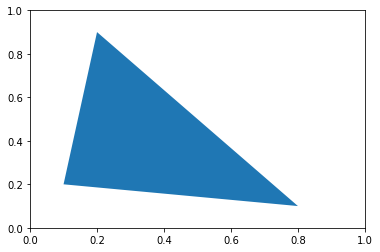

In [11]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

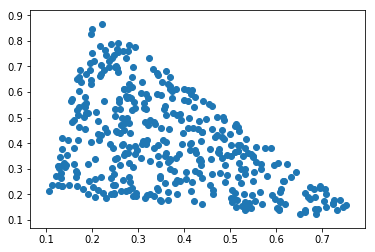

In [12]:
unf = np.ones((2,400))
for i in range(400):
    unf[0,i] = rng()
    unf[1,i] = rng()
    if unf[0,i] + unf[1,i] > 1:
        t = unf[0,i]
        unf[0,i] = unf[0,i] - (unf[0,i]+unf[1,i] -1)
        unf[1,i] = unf[1,i] -(t +unf[1,i] -1)
    t = unf[0,i]
    unf[0,i] = 0.7*t + 0.1*unf[1,i] + 0.1
    unf[1,i] = -0.1*t + 0.7*unf[1,i] + 0.2

plt.scatter(unf[0,:], unf[1,:])
plt.show()

### Exercise
Sample 100 point uniformly distributed inside the unit circle. Check that your method does not produce any rejected points. Plot sampled points.

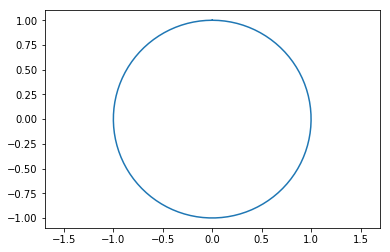

In [13]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

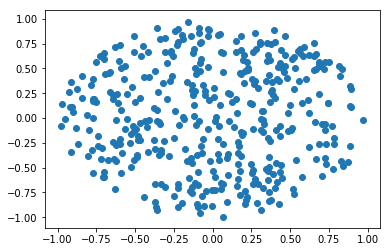

In [14]:
unf = np.ones((2,400))
a1 = []
a2 = []
pi = 3.14
for i in range(400):
    unf[0,i] = rng()*2*pi
    unf[1,i] = math.sqrt(rng())
    a1.append(np.sin(unf[0,i])*unf[1,i])
    a2.append(np.cos(unf[0,i])*unf[1,i])
plt.scatter(a1, a2)
plt.show()

## Random normal generator

### Exercise
Check theoretically and numerically that the following algorithm (also called Box-Muller algorithm) generates pairs of independent N(0,1) variables. Modify it to exclude ```np.sin``` and ```np.cos``` calls.

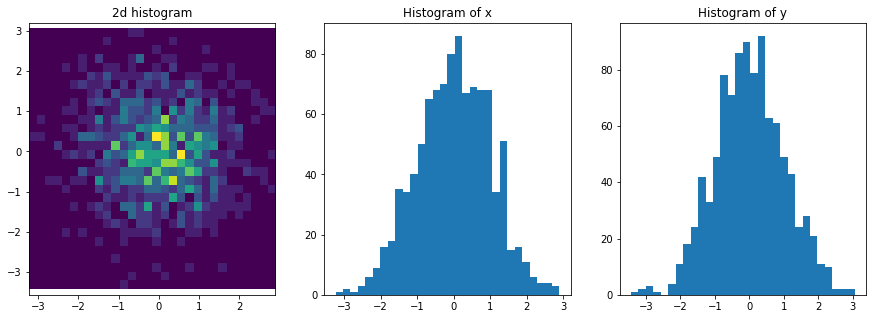

In [15]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

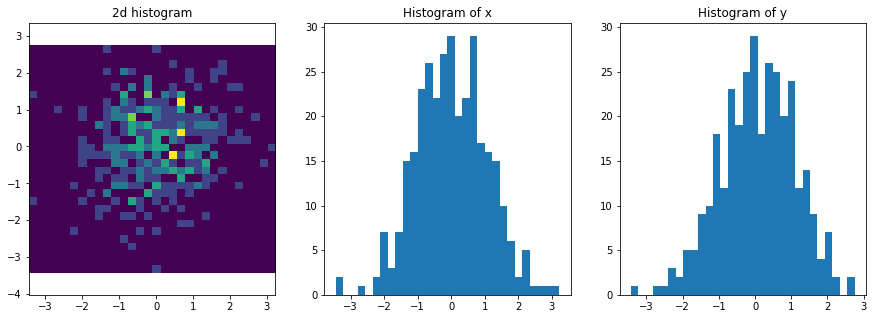

In [16]:
'''Let U and V be independent random variables that are uniformly distributed on [0,1]. Therefore,
X = sqrt(-2*ln(U))*cos(2*Pi*V)
Y = sqrt(-2*ln(U))*sin(2*Pi*V)
are independent and N(0,1)-distributed.

Proof:

R = sqrt(-2*ln(U))
It is to show that P(R<= x) = 1 - exp(-x^2/2)
Q = 2*Pi*V -> Q - U(0,2*Pi)
We want to find g for which:
(X, Y) = g(R,Q)
     or
P(X,Y)=P(R,Q)∘g−1
When by using transformation formula for densities, we calculate density of (X,Y) and get that X & Y
are independent and N(0,1)-distributed.
If density of R is f(x)= x*e^(-x^2/2) and V - U(0,1), so density of Q=2*Pi*V is g(y)= 1/(2*Pi)*I{0<=x<=2*Pi}
It means that density of (R, Q) is F(x,y)=f(x)*g(y) (by independency)
X=R*cosQ Y=R*sinQ so density of (X,Y) is A(x,y) = F(x,y)/|det(J)|= F(x,y)/R = 1/(2*Pi)*e^(-(x^2+y^2)/2) 
The last expression means that X and Y are independent and - N(0, 1)'''


u1, u2 = (np.random.rand(2, 400)-0.5)*2
sum = u1*u1 + u2*u2
x=[]
y=[]
for i in range(400):
    if (sum[i]!=0) and (sum[i]<1):
        x.append(u1[i] * np.sqrt(-2*np.log(sum[i])/sum[i]))
        y.append(u2[i] * np.sqrt(-2*np.log(sum[i])/sum[i]))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

## Markov Chain Monte Carlo (MCMC)

Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример расстановки значений по вершинам графа (черные вершины имеют значение 1, белые - 0):

![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg)

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) = 
 \begin{cases}
   \frac{1}{Z_G}, &\xi - \text{допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$\begin{equation*}
{\rm E} n(\xi) = \sum_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum_{x \in \{0,1\}^V} n(x) {\rm I}_{\{\xi - \text{допустимая} \}}
\end{equation*}$$

Явно перебирать все $x \in \{0,1\}^{V}$ сложновато. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чисел:
$$\begin{equation*}
{\rm E} n(\xi) \approx \frac{1}{N} \sum_{i=1}^{N} n(\xi), \text{где } \xi \sim \mu
\end{equation*}$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом нам поможет метод MCMC.

### Метод MCMC

Предназначение: приближенное моделирование случаных величин из заданного распредедения 

Идея:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Вот как это работает https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,multimodal

Алгоритм:
* пусть $\pi$ - заданное распределение (не обязательно нормированное к 1) на множестве $\Omega$
* пусть $Q = (q_{i,j})$ - матрица переходных вероятностей произвольной цепи Маркова с состояниями из $\Omega$
* выберем произвольное $X_0$ из $\Omega$
* для текущего $X_n$ смоделируем значение $Z_{n+1}$ из распределения $q_{X_n, \cdot}$
* смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi_j q_{j,i}}{\pi_i q_{i,j}} )
$$
* если $\alpha$ = 1, то $X_{n+1} = Z_{n+1}$, иначе $X_{n+1} = X_{n}$.

Обоснование и доказательства можно почитать здесь http://probability.ca/jeff/ftpdir/johannes.pdf

Некоторые типичные способы задания $q$:
* Metropolis algorithm: $q_{i,j} = q_{j,i}$
* Random walk Metropolis-Hastings: $q_{i,j} = q(j - i)$
* Independence sampler: $q_{i,j} = q(j)$ independent of $i$

### Задание
1) Описать применение МСМС к задаче оценки  ${\rm E} n(\xi)$, доказать все попутные утверждения

2) Оценить  ${\rm E} n(\xi)$ с помощью МСМС

3) Построить график распределеиня $n(\xi)$

4) Реализовать генератор случайных графов с допустимыми конфигурациями.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(narr):
    '''Plots 2d lattice with vertices colored in black and red according to given mask.
    Vertice is colored black if narr[i, j] == True and red otherwise.
    
    Parameters
    ----------
    narr : 2d boolean ndarray.
        Mask for vertices colors.
    '''

    if narr.dtype != 'bool':
        raise ValueError('narr should be a boolean ndarray')
    colors = np.full_like(narr, 'red', dtype='U5')
    colors[narr] = 'black'
    x, y = np.indices((narr.shape))
    plt.scatter(x, y, c=colors.ravel())
    plt.show()

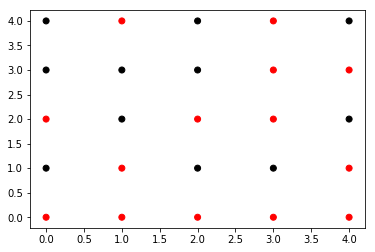

In [18]:
size = 5
narr = np.random.choice([True, False], size=(size, size))
plot_grid(narr)

In [19]:
'''We can apply MCMC method using the next algorithm:
   1. Pick a vertex v ∈ V uniformly at random
   2. Toss a fair coin
   3. If the coin heads and if all neighbors of v take the value 0 in Xn, then set
      Xn+1 = 1. Otherwise, Xn+1 = 0.
   4. Leave the value for all other vertices unchanged, that is: Xn+1(w) =
      Xn(w) ∀ w 6= v.

The resulting Markov chain is irreducible for the following reason: Given a feasible
configuration ξ, we can reach the "all 0" configuration in a finite number of steps.
From there on we can reach any other feasible configuration ξ'. Moreover,
the chain is aperiodic since we can go from ξ to ξ in one step. It remains to
show that µG is reversible (and hence stationary for the chain). 
For two feasible configurations ξ and ξ' we need to check that
µG(ξ)Pξ,ξ' = µg(ξ')P(ξ',ξ).
We split the problem into three different cases. If the configurations are exactly
the same, the equation is trivial. Secondly, if the configurations differ in more than
two vertices, the equation is also obvious since the algorithm changes only one
vertex at a time. Finally, assume the configurations differ at a single vertex v.
All neighbors of ξ and ξ' must then be 0 because we deal with feasible configurations.
We then get:
µG(ξ)Pξ,ξ0 =1/(ZG*2k)= µg(ξ')Pξ',ξ.
Hence our chain is reversible with respect to µG and µG is also the stationary distribution.

Thus the algorithm is correct.
'''
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1


size = 10
mean = 0
for i in range(100):
    sample=np.zeros((size, size))
    for j in range(size*size*size):
        x=int((size*rng())//1)
        y=int((size*rng())//1)
        up=0
        down=0
        left=0
        right=0
        if (x==0) or (sample[x-1,y]==0):
            up=1
        if (x==size-1) or (sample[x+1,y]==0):
            down=1
        if (y==0) or (sample[x,y-1]==0):
            left=1
        if (y==size-1) or (sample[x,y+1]==0):
            right=1    
        if (rng()>0.5) and (up==1) and (down==1) and (left==1) and (right==1):
            sample[x,y]=1
    mean=mean+np.sum(sample)     
print(mean/100)  

38.45


### Submit to https://goo.gl/forms/aszSXdC53VV19kwx2